## Importações

In [1]:
from funcoes.funcoes import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
# importando dados

df_dados = pd.read_csv('dados/loan_data_2007_2014_preprocessed.zip', index_col=0)

---

# 1. Calculando o Índice de Perda por Inadimplência e Exposição em Caso de Inadimplência

## 1.1 Loss Given Default - LGD


Para calcular LGD, perda por inadimplência, é preciso calcular a porcentagem de exposição recuperada após a inadimplência do mutuário. A LGD total de uma instituição financeira é calculada após uma análise de todos os empréstimos pendentes usando as perdas e a exposição acumuladas. 

Seu cálculo será:

`LGD = 1 - taxa de recuperação`

Primeiro serão selecionandos apenas os dados dos mutuários que entraram em default.

In [4]:
LC_defaults = df_dados[df_dados['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]

### 1.1.1 Variáveis independentes

In [6]:
# verificando valores nan
# nenhum tratamento será necessário para as variáveis independentes

pd.options.display.max_rows = None

LC_defaults.isnull().sum()

Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                                          2337
home_ownership                                     

### 1.1.2 Variáveis dependentes

- **recoveries:** Pós cobrança da recuperação bruta;
- **funded_amnt:** O valor total comprometido com esse empréstimo naquele momento.

O cálculo da taxa de recuperação será realizado, mas seu valor máximo fica um pouco acima de 1 (por ser uma taxa ela deve estar entre 0 e 1), o que pode acontecer durante os cálculos.

In [7]:
LC_defaults['taxa_recuperacao'] = LC_defaults['recoveries'] / LC_defaults['funded_amnt']
LC_defaults['taxa_recuperacao'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: taxa_recuperacao, dtype: float64

In [8]:
# corrigindo a taxa de recuperação

LC_defaults['taxa_recuperacao'] = np.where(LC_defaults['taxa_recuperacao'] > 1, 1, LC_defaults['taxa_recuperacao'])
LC_defaults['taxa_recuperacao'] = np.where(LC_defaults['taxa_recuperacao'] < 0, 0, LC_defaults['taxa_recuperacao'])
LC_defaults['taxa_recuperacao'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: taxa_recuperacao, dtype: float64

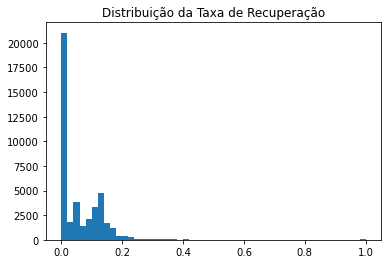

In [9]:
plt.title('Distribuição da Taxa de Recuperação')
plt.hist(LC_defaults['taxa_recuperacao'], bins = 50);

Criando uma variável para a taxa de recuperação, onde será aplicada a regressão logística e se a `taxa_recuperacao` for zero, a taxa de recuperação será zero. Onde for maior do que zero, será usada a Regressão Linear para estimá-la.

In [10]:
LC_defaults['taxa_recuperacao_0_1'] = np.where(LC_defaults['taxa_recuperacao'] == 0, 0, 1)

## 1.2 Exposure at Default - EAD
---

EAD, exposição em caso de inadimplência, é o valor total ao qual uma instituição financeira está exposta quando um empréstimo entra em default. 

Pode ser calculado por:

`EAD = valor total financiado * fator de conversão de crédito`

### 1.2.1 Calculando o fator de conversão de crédito

- **funded_amnt:** O valor total comprometido com esse empréstimo naquele momento;
- **total_rec_prncp:** Principal recebido até o momento.

In [11]:
LC_defaults['fator_conversao_credito'] = (LC_defaults['funded_amnt'] - LC_defaults['total_rec_prncp']) / LC_defaults['funded_amnt']
LC_defaults['fator_conversao_credito'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: fator_conversao_credito, dtype: float64

Observando a distribuição beta, a mesma da taxa de recuperação, que nesse caso será aplicada a Regressão Linear, já que fatores de conversão são mais homogeaneamente distribuídos. 

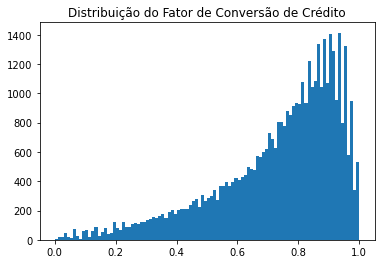

In [12]:
plt.title('Distribuição do Fator de Conversão de Crédito')
plt.hist(LC_defaults['fator_conversao_credito'], bins = 100);

---

*Esse dataset foi criado para a Regressão Linear do notebook de índice de perda por inadimplência, será a junção das variáveis e dummies das variáveis selecionadas por WoE e IV com as taxas e fator de conversão criados neste notebook*

In [13]:
dados_WoE_VI = pd.read_csv('dados/selected_data.zip')

In [14]:
df2 = pd.concat([dados_WoE_VI, LC_defaults[['taxa_recuperacao', 'taxa_recuperacao_0_1', 
                                            'fator_conversao_credito','funded_amnt','total_rec_prncp',
                                            'recoveries']]], axis = 1)
df2.fillna(0, inplace=True)

In [15]:
df2.to_csv('dados/dados_WoE_VI_LGD_EAD_regressao.csv', index=False)

---